In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
class GMM(nn.Module):
    def __init__(self, n_comp, device, min_covar=1e-6, params=None):
        self.device = device
        self.n_comp = n_comp
        self.sig_stability = min_covar*torch.eye(2).to(device)

        # initialize GMM parameters
        if params is not None:
            self.pi = params[0]
            self.mu = params[1]
            self.sig = params[2]
        else:
            self.pi = torch.ones((n_comp))/n_comp
            self.mu = torch.randn((n_comp, 2))
            self.sig = (torch.eye(2)[None,...]).repeat(n_comp,1,1)

        self.pi, self.mu, self.sig = self.pi.to(device), self.mu.to(device), self.sig.to(device)

    def sample(self, n_samples):
        sel_comp = np.random.choice(a=self.n_comp, size=n_samples, p=self.pi.cpu().numpy())
        L = torch.linalg.cholesky(self.sig + self.sig_stability[None,...])
        return self.mu[sel_comp] + torch.einsum('bij,bj->bi',L[sel_comp],torch.randn(n_samples,2,device=self.device))

    def pdf(self, x, mu, sig):
        # evaluate multivariate probability density function for a Gaussian 
        fact = 1/(torch.sqrt(torch.linalg.det(sig + self.sig_stability))*2*np.pi)
        return fact*torch.exp(-0.5*torch.einsum('bj,bj->b', (x - mu), torch.einsum('ij,bi->bj',torch.linalg.inv(sig+self.sig_stability),(x - mu))))

    def fit(self, x, max_iter, eps=1e-6):
        S = x.shape[0]
        neglogllh = [] # track negative log-likelihood

        for iter in range(max_iter):
            # compute likelihood
            likelihood = torch.zeros((S, self.n_comp)).to(x.device)         
            for comp in range(self.n_comp):
                likelihood[:,comp] = self.pdf(x, self.mu[comp],self.sig[comp])
            
            # Expectation: re-compute responsibilites
            numerator = likelihood * self.pi
            denominator = numerator.sum(axis=1)[:, np.newaxis]
            w = numerator / denominator          

            # Maximization: re-compute GMM parameters
            N = w.sum(0)
            self.mu = (w[:,:,None]*x[:,None,:]).sum(0)/N[:,None]

            xh = x[:,None,:] - self.mu[None,...]
            self.sig = torch.einsum('bki,bkj->kij',torch.einsum('bk,bkj->bkj',w,xh),xh)/N[:,None,None]
            self.pi = N/(x.shape[0])

            # logging negative log-likelihood
            neglogllh.append(-torch.log(numerator.sum(-1)).sum().item())

            # check stopping criterion
            if iter >= 2 and (np.abs(neglogllh[-1]-neglogllh[-2]) <= eps):
                print('\nGaussian mixture model: stopping criterion evoked in iteration %i' %iter)
                break

        return neglogllh

torch.Size([2000, 2])


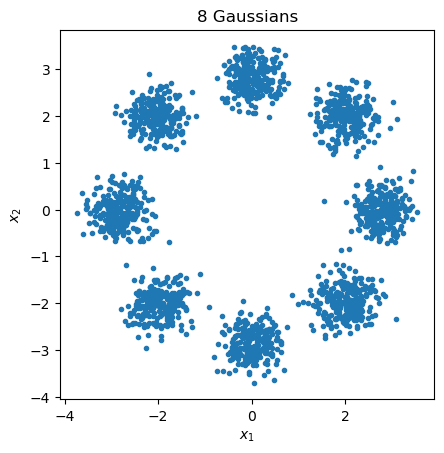

In [3]:
# generate data
n_samples = 2000
z = torch.randn(n_samples, 2)

sq = 1./np.sqrt(2)
fact = 4.*sq
mus = [fact*torch.Tensor([[1.],[0.]]), fact*torch.Tensor([[-1.],[0.]]), fact*torch.Tensor([[0.],[1.]]), fact*torch.Tensor([[0.],[-1.]]),\
    fact*torch.Tensor([[sq],[sq]]), fact*torch.Tensor([[-sq],[sq]]), fact*torch.Tensor([[sq],[-sq]]), fact*torch.Tensor([[-sq],[-sq]])]

sig = 0.1 * torch.Tensor([[1.,0.0],[0.0,1.]])
x_all = [mu + torch.linalg.cholesky(sig)@torch.randn(2,int(n_samples/8.)) for mu in mus]
x = torch.hstack(x_all).T
mus = torch.hstack(mus) # 2,8
print(x.shape)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal', 'box')
ax.scatter(x[:,0],x[:,1],marker='.'), plt.title('8 Gaussians')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [4]:
# settings
max_iter = 1000
n_comp = 10
n_samples = 2000
eps = 1.0E-6 # min_cov for stability


Gaussian mixture model: stopping criterion evoked in iteration 96


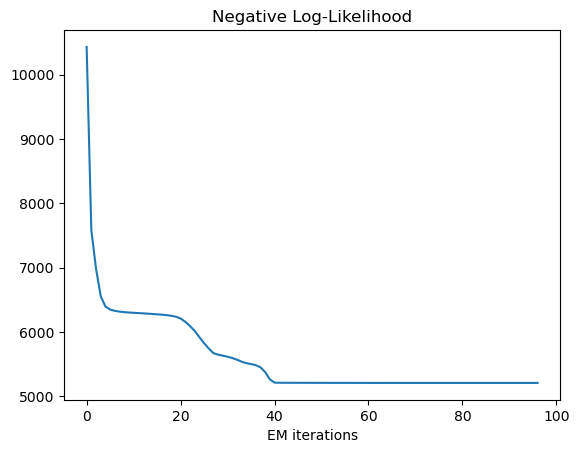

In [13]:
# estimate density
gmm = GMM(n_comp=n_comp, device=x.device)
neglogllh = gmm.fit(x=x, max_iter = max_iter, eps=eps)

# neg log likelihood plot
plt.figure()
plt.title('Negative Log-Likelihood'), plt.xlabel('EM iterations')
plt.plot(neglogllh)
plt.show()

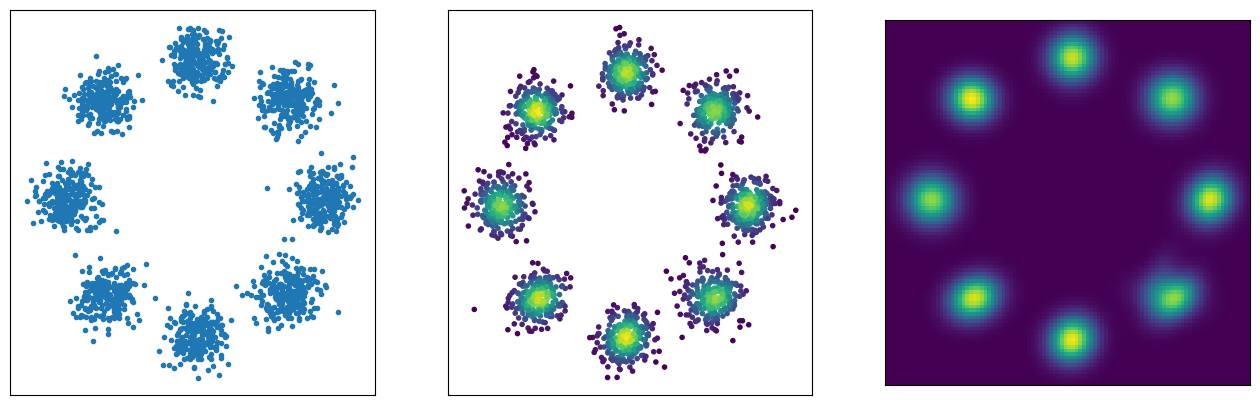

In [14]:
# sample from gmm and evaluate likelihood
samples = gmm.sample(n_samples)
likelihood_samples = torch.zeros((samples.shape[0], gmm.n_comp)).to(x.device)
for comp in range(gmm.n_comp):
    likelihood_samples[:,comp] = gmm.pdf(samples.to(x.device),gmm.mu[comp],gmm.sig[comp])
numerator_samples = likelihood_samples * gmm.pi
f_samples = numerator_samples.sum(-1)    

# plot fitted GMM over data range
min_val, max_val = x.min(), x.max()
yy, xx = torch.meshgrid(torch.linspace(min_val,max_val,100),torch.linspace(min_val,max_val,100)) 
x_test = torch.stack((xx.ravel(),yy.ravel())).T.to(x.device)
likelihood = torch.zeros((x_test.shape[0], gmm.n_comp)).to(x.device)
for comp in range(gmm.n_comp):
    likelihood[:,comp] = gmm.pdf(x_test.to(x.device),gmm.mu[comp],gmm.sig[comp])
numerator = likelihood * gmm.pi
f = numerator.sum(-1)    

# plotting
fontsize = 14 
fig, ax = plt.subplots(1,3,figsize=(16,5))
ax[0].scatter(x[:,0].cpu(),x[:,1].cpu(),marker='.'), ax[0].set_xticks([]), ax[0].set_yticks([])
# plot estimated density
ax[1].scatter(samples[:,0].cpu(),samples[:,1].cpu(),c=f_samples,marker='.'), ax[1].set_xticks([]), ax[1].set_yticks([])
# plot generated samples
ax[2].imshow(f.reshape(xx.shape[0],xx.shape[1]),origin='lower'), ax[2].set_xticks([]), ax[2].set_yticks([])
plt.savefig(os.getcwd() + '/out/gmm.png', bbox_inches='tight')
plt.show()